In [1]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

In [2]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [3]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1005,
            'bin_width': 1.0,
        },
    },
}

In [4]:
featurizer = SpectrumFeaturizer(config, mode='torch')

In [5]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [6]:
msn_dataset[0]

{'spec': Data(x=[14, 1005], edge_index=[2, 13]),
 'mol': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'precursor_mz': tensor(347.1489),
 'adduct': '[M+H]+',
 'identifier': '0000002_0000000',
 'mol_freq': tensor(1.)}

In [7]:
len(msn_dataset)

16476

In [8]:
len(msn_dataset.trees)

16476

In [9]:
msn_dataset.trees[0]

347.14891
  329.139404296875
    175.075592041016
    160.051956176758
  193.086303710938
    151.075317382813
    107.049133300781
  175.076354980469
  155.070388793945
    112.051902770996
    95.049163818359
  151.075546264648
    135.044143676758
    107.049140930176

## Node similarities

In [10]:
import os
import random
from collections import defaultdict, deque
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats  # for t-tests, ranksum, etc.

from matchms import Spectrum
from matchms.similarity import CosineGreedy, CosineHungarian

In [14]:
def summarize_similarity_distribution(scores: List[float]) -> dict:
    """
    Return mean, std, median, count for a list of float scores,
    ignoring NaNs.
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "median": float(np.median(arr)),
        "count": len(arr)
    }

def compare_distributions(distA: List[float], distB: List[float], test_type: str = "ttest") -> float:
    """
    Compare two distributions (lists of floats) with a chosen test, e.g. 'ttest' or 'ranksum'.
    Return the p-value.

    - "ttest": a standard two-sample t-test
    - "ranksum": a nonparametric Wilcoxon rank-sum test
    """
    arrA = np.array(distA)
    arrB = np.array(distB)
    arrA = arrA[~np.isnan(arrA)]
    arrB = arrB[~np.isnan(arrB)]
    if len(arrA) < 2 or len(arrB) < 2:
        return float('nan')

    if test_type.lower() == "ttest":
        _, pval = stats.ttest_ind(arrA, arrB, equal_var=False, nan_policy='omit')
        return pval
    elif test_type.lower() == "ranksum":
        _, pval = stats.ranksums(arrA, arrB)
        return pval
    else:
        raise ValueError(f"Unknown test_type: {test_type}")

def plot_histograms(
    distributions: Dict[str, List[float]],
    bins: int = 50,
    alpha: float = 0.5,
    title: str = "Histogram of Similarities",
    xlabel: str = "Similarity",
    ylabel: str = "# of pairs"
):
    """
    distributions: { "label": [scores], ... }
    """
    plt.figure(figsize=(6,4))
    for label, scores in distributions.items():
        arr = np.array(scores)
        arr = arr[~np.isnan(arr)]
        plt.hist(arr, bins=bins, alpha=alpha, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()

###############################################
# 1) Cosine Similarity (matchms)
###############################################

def compute_cosine_greedy_score(specA: Spectrum, specB: Spectrum,
                                tolerance: float=0.1, mz_power: float=0.0,
                                intensity_power: float=1.0) -> Tuple[float,int]:
    """
    matchms CosineGreedy. Returns (score, matched_peaks).
    """
    if specA is None or specB is None:
        return (float('nan'), 0)
    cos = CosineGreedy(tolerance=tolerance, mz_power=mz_power, intensity_power=intensity_power)
    result = cos.pair(specA, specB)
    return (result["score"], result["matches"])

def compute_cosine_hungarian_score(specA: Spectrum, specB: Spectrum,
                                   tolerance: float=0.1, mz_power: float=0.0,
                                   intensity_power: float=1.0) -> Tuple[float,int]:
    """
    matchms CosineHungarian. Returns (score, matched_peaks).
    """
    if specA is None or specB is None:
        return (float('nan'), 0)
    cos = CosineHungarian(tolerance=tolerance, mz_power=mz_power, intensity_power=intensity_power)
    result = cos.pair(specA, specB)
    return (result["score"], result["matches"])

###############################################
# 2) DreaMS Embedding Similarity
###############################################

def dreams_embedding_similarity(embA: np.ndarray, embB: np.ndarray) -> float:
    """
    Simple cosine similarity for DreaMS or other embeddings
    stored as np.ndarray or torch.Tensor.
    """
    if embA is None or embB is None:
        return float('nan')
    if isinstance(embA, torch.Tensor):
        embA = embA.cpu().numpy()
    if isinstance(embB, torch.Tensor):
        embB = embB.cpu().numpy()

    dot = np.dot(embA, embB)
    normA = np.linalg.norm(embA)
    normB = np.linalg.norm(embB)
    if normA == 0.0 or normB == 0.0:
        return 0.0
    return dot / (normA * normB)

###############################################
# 3) Getting info from TreeNodes
###############################################

def get_spectrum(node) -> Optional[Spectrum]:
    """Return the matchms.Spectrum from a node."""
    if node is None or node.spectrum is None:
        return None
    return node.spectrum

def get_embedding_for_node(node, embeddings_dict: Dict[str, np.ndarray]) -> Optional[np.ndarray]:
    """Return embedding from a dictionary that maps identifier->embedding."""
    if node is None or node.spectrum is None:
        return None
    identifier = node.spectrum.get('identifier', None)
    if identifier is None:
        return None
    return embeddings_dict.get(identifier, None)

def get_ms_level(node) -> Optional[int]:
    """Return the ms_level from node's spectrum metadata if present."""
    if node is None or node.spectrum is None:
        return None
    ms_level_str = node.spectrum.get('ms_level', None)
    if ms_level_str is not None:
        return int(ms_level_str)
    return None

###############################################
# 4) BFS-based Relationship Computations
###############################################

def compute_ancestor_descendant_similarity(tree,
                                           use_embedding: bool=False,
                                           sim_fn=None,
                                           embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
                                           tolerance: float=0.1) -> List[float]:
    """
    For each parent->child in the tree, compute similarity.
    If use_embedding=False, sim_fn is expected to be like (specA, specB)->(score, matched).
      If None, we use default compute_cosine_greedy_score with tolerance=0.1.
    If use_embedding=True, sim_fn is expected to be (embA, embB)->float or None
      If None, we use dreams_embedding_similarity.

    Returns a list of similarity scores (floats).
    """
    scores = []
    queue = deque([tree.root])
    while queue:
        parent = queue.popleft()
        for child in parent.children.values():
            score = None
            if not use_embedding:
                # Spectral
                specA = get_spectrum(parent)
                specB = get_spectrum(child)
                if sim_fn is None:
                    (sc, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
                else:
                    (sc, _) = sim_fn(specA, specB)
                score = sc
            else:
                # Embedding
                embA = get_embedding_for_node(parent, embeddings_dict)
                embB = get_embedding_for_node(child, embeddings_dict)
                if sim_fn is None:
                    sc = dreams_embedding_similarity(embA, embB)
                else:
                    sc = sim_fn(embA, embB)
                score = sc
            scores.append(score)
            queue.append(child)
    return scores

def compute_sibling_similarity(tree,
                               use_embedding: bool=False,
                               sim_fn=None,
                               embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
                               tolerance: float=0.1) -> List[float]:
    """
    For each parent, compute pairwise similarity among sibling nodes.
    Return a list of the resulting scores.
    """
    scores = []
    queue = deque([tree.root])
    while queue:
        parent = queue.popleft()
        sibling_nodes = list(parent.children.values())
        for i in range(len(sibling_nodes)):
            for j in range(i+1, len(sibling_nodes)):
                nodeA = sibling_nodes[i]
                nodeB = sibling_nodes[j]
                if not use_embedding:
                    specA = get_spectrum(nodeA)
                    specB = get_spectrum(nodeB)
                    if sim_fn is None:
                        (sc, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
                    else:
                        (sc, _) = sim_fn(specA, specB)
                    scores.append(sc)
                else:
                    embA = get_embedding_for_node(nodeA, embeddings_dict)
                    embB = get_embedding_for_node(nodeB, embeddings_dict)
                    if sim_fn is None:
                        sc = dreams_embedding_similarity(embA, embB)
                    else:
                        sc = sim_fn(embA, embB)
                    scores.append(sc)

        for child in sibling_nodes:
            queue.append(child)

    return scores

def detect_chimeric_branches(tree,
                             margin: float=0.2,
                             use_embedding: bool=False,
                             sim_fn=None,
                             embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
                             tolerance: float=0.1) -> Dict[str, bool]:
    """
    For each node, compare sim(node, parent) vs best sim(node, other).
    If best-other minus parent-sim > margin => chimeric.

    Return dict: {node_identifier -> bool}
    """
    all_nodes = []
    queue = deque([tree.root])
    while queue:
        n = queue.popleft()
        all_nodes.append(n)
        for c in n.children.values():
            queue.append(c)

    def _compute_node_sim(nA, nB):
        if not use_embedding:
            sA = get_spectrum(nA)
            sB = get_spectrum(nB)
            if sim_fn is None:
                (score, _) = compute_cosine_greedy_score(sA, sB, tolerance=tolerance)
            else:
                (score, _) = sim_fn(sA, sB)
            return score
        else:
            eA = get_embedding_for_node(nA, embeddings_dict)
            eB = get_embedding_for_node(nB, embeddings_dict)
            if sim_fn is None:
                return dreams_embedding_similarity(eA, eB)
            else:
                return sim_fn(eA, eB)

    # helper BFS to find parent
    def _find_parent(root_node, target):
        qq = deque([root_node])
        while qq:
            curr = qq.popleft()
            for child in curr.children.values():
                if child is target:
                    return curr
                qq.append(child)
        return None

    chimeric_dict = {}
    for node in all_nodes:
        if node is tree.root or node.spectrum is None:
            nid = node.spectrum.get('identifier','root') if node.spectrum else 'root'
            chimeric_dict[nid] = False
            continue
        parent = _find_parent(tree.root, node)
        if parent is None:
            # shouldn't happen if the tree is well formed
            nid = node.spectrum.get('identifier','???')
            chimeric_dict[nid] = False
            continue

        sim_parent = _compute_node_sim(node, parent)
        best_other = -1.0
        for other in all_nodes:
            if other is node or other is parent:
                continue
            sc = _compute_node_sim(node, other)
            if sc > best_other:
                best_other = sc

        nid = node.spectrum.get('identifier','???')
        if best_other - sim_parent > margin:
            chimeric_dict[nid] = True
        else:
            chimeric_dict[nid] = False

    return chimeric_dict

###############################################
# 5) Random node pairs across entire dataset
###############################################

def random_node_pairs(
    msn_dataset,
    num_pairs: int=1000,
    use_embedding: bool=False,
    sim_fn=None,
    embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
    tolerance: float=0.1
) -> List[float]:
    """
    Gather all nodes from all trees, sample random pairs, compute similarity.
    Return list of scores.
    """
    # gather nodes
    all_nodes = []
    for tree in msn_dataset.trees:
        queue = deque([tree.root])
        while queue:
            n = queue.popleft()
            all_nodes.append(n)
            for c in n.children.values():
                queue.append(c)

    if len(all_nodes) < 2:
        return []

    def _node_sim(nA, nB):
        if not use_embedding:
            sA = get_spectrum(nA)
            sB = get_spectrum(nB)
            if sim_fn is None:
                (sc, _) = compute_cosine_greedy_score(sA, sB, tolerance=tolerance)
            else:
                (sc, _) = sim_fn(sA, sB)
            return sc
        else:
            eA = get_embedding_for_node(nA, embeddings_dict)
            eB = get_embedding_for_node(nB, embeddings_dict)
            if sim_fn is None:
                return dreams_embedding_similarity(eA, eB)
            else:
                return sim_fn(eA, eB)

    scores = []
    for _ in range(num_pairs):
        A = random.choice(all_nodes)
        B = random.choice(all_nodes)
        if A is B:  # skip if same
            continue
        sc = _node_sim(A,B)
        scores.append(sc)
    return scores

###############################################
# 6) Pairwise Similarity by MS Level
###############################################

def compute_same_level_similarity_limited(
    msn_dataset,
    target_level: int = 2,
    use_embedding: bool = False,
    sim_fn=None,
    embeddings_dict: Optional[Dict[str, np.ndarray]] = None,
    tolerance: float = 0.1,
    max_pairs: int = 500
) -> List[float]:
    """
    Collect *all* nodes from ALL trees with ms_level == target_level,
    then compute pairwise similarity among them (excluding node with itself).

    If the number of total pairs is small enough (< max_pairs), do them all.
    Otherwise, randomly sample up to max_pairs pairs.

    If use_embedding=False, we interpret sim_fn as (specA, specB)->(score, matched_peaks).
      If sim_fn is None => default CosineGreedy(tol=0.1).
    If use_embedding=True, we interpret sim_fn as (embA, embB)->float.
      If sim_fn is None => default dreams_embedding_similarity.

    Returns
    -------
    List of similarity scores (float).
    """
    from collections import deque
    from math import comb
    import random

    # 1) Gather nodes at target_level
    nodes_at_level = []
    for tree in msn_dataset.trees:
        queue = deque([tree.root])
        while queue:
            node = queue.popleft()
            if node.spectrum is not None:
                lvl_str = node.spectrum.get("ms_level", None)
                if lvl_str is not None and int(lvl_str) == target_level:
                    nodes_at_level.append(node)
            for child in node.children.values():
                queue.append(child)

    n = len(nodes_at_level)
    if n < 2:
        return []

    # total number of pairs
    total_pairs = comb(n, 2)  # n*(n-1)//2

    # 2) Decide if we do all pairs or random sampling
    if total_pairs <= max_pairs:
        # do them all
        pairs = []
        for i in range(n):
            for j in range(i+1, n):
                pairs.append((nodes_at_level[i], nodes_at_level[j]))
    else:
        # randomly sample max_pairs distinct pairs
        # An easy approach is to sample from all combinations with random indices
        pairs = []
        indices = list(range(n))
        # We can do repeated random picks until we get max_pairs
        # but to ensure uniqueness, we might do reservoir approach or
        # simply do random combinations with a limit.
        # A quick method: pick random i,j until we fill max_pairs
        seen = set()
        attempts = 0
        while len(pairs) < max_pairs and attempts < max_pairs*10:
            i = random.randint(0, n-1)
            j = random.randint(0, n-1)
            if i < j:
                if (i,j) not in seen:
                    seen.add((i,j))
                    pairs.append((nodes_at_level[i], nodes_at_level[j]))
            elif j < i:
                if (j,i) not in seen:
                    seen.add((j,i))
                    pairs.append((nodes_at_level[j], nodes_at_level[i]))
            attempts += 1

    # 3) For each pair, compute similarity
    sims = []
    for (nodeA, nodeB) in pairs:
        if not use_embedding:
            specA = get_spectrum(nodeA)
            specB = get_spectrum(nodeB)
            if sim_fn is None:
                (score, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
            else:
                (score, _) = sim_fn(specA, specB)
            sims.append(score)
        else:
            embA = get_embedding_for_node(nodeA, embeddings_dict)
            embB = get_embedding_for_node(nodeB, embeddings_dict)
            if sim_fn is None:
                sc = dreams_embedding_similarity(embA, embB)
            else:
                sc = sim_fn(embA, embB)
            sims.append(sc)

    return sims



=== CosineGreedy Analysis ===
Ancestor-Descendant (Greedy) stats: {'mean': 0.4131146339090848, 'std': 0.2766338340188168, 'median': 0.358482554701118, 'count': 166808}
Sibling (Greedy) stats: {'mean': 0.2600110785894002, 'std': 0.30694811712740605, 'median': 0.11463458831076889, 'count': 173661}
Random pairs (Greedy) stats: {'mean': 0.027933932417002448, 'std': 0.08342354453568447, 'median': 0.0017816062095354934, 'count': 5000}


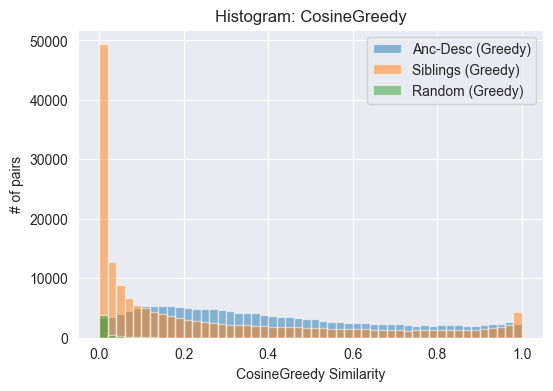


=== CosineHungarian Analysis ===
Ancestor-Descendant (Hungarian) stats: {'mean': 0.41311503931629406, 'std': 0.2766341832752525, 'median': 0.358482554701118, 'count': 166808}
Sibling (Hungarian) stats: {'mean': 0.2600110815415143, 'std': 0.3069481175822487, 'median': 0.11463458831076889, 'count': 173661}
Random pairs (Hungarian) stats: {'mean': 0.026995980242722793, 'std': 0.08281074355878305, 'median': 0.0013461303573971762, 'count': 5000}


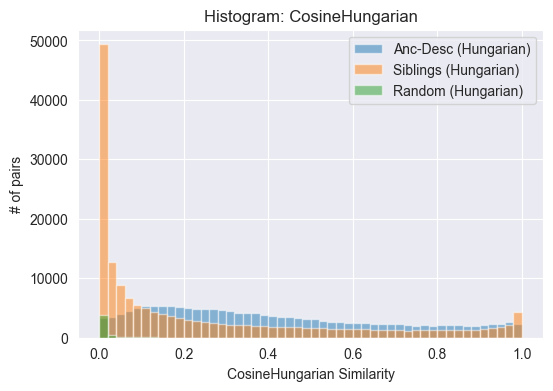


=== MS level pair analysis (CosineGreedy) ===
Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242}
Level pair (4, 4) -> {'mean': 0.24120319032465876, 'std': 0.32201527994996815, 'median': 0.0727915126063649, 'count': 250039}
Level pair (2, 5) -> {'mean': 0.07193860604153023, 'std': 0.11487458429477933, 'median': 0.02658169835400203, 'count': 14511}
Level pair (3, 5) -> {'mean': 0.17168872250009667, 'std': 0.22198916240377284, 'median': 0.08056879358545516, 'count': 72724}
Level pair (4, 5) -> {'mean': 0.27896573058598184, 'std': 0.323408384174

In [36]:
# 2) COSINE GREEDY analysis
print("\n=== CosineGreedy Analysis ===")
# 2a) Ancestor-Descendant
ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(tree,
                                                  use_embedding=False,  # spectral
                                                  sim_fn=None)  # None => default CosineGreedy
    ad_sims.extend(sims)
stats_ad = summarize_similarity_distribution(ad_sims)
print("Ancestor-Descendant (Greedy) stats:", stats_ad)

# 2b) Sibling
sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(tree, use_embedding=False, sim_fn=None)
    sib_sims.extend(sims)
stats_sib = summarize_similarity_distribution(sib_sims)
print("Sibling (Greedy) stats:", stats_sib)

# 2c) Random
rand_sims = random_node_pairs(msn_dataset, num_pairs=5000, use_embedding=False)
stats_rand = summarize_similarity_distribution(rand_sims)
print("Random pairs (Greedy) stats:", stats_rand)

# Plot
plot_histograms({
    "Anc-Desc (Greedy)": ad_sims,
    "Siblings (Greedy)": sib_sims,
    "Random (Greedy)": rand_sims
},
title="Histogram: CosineGreedy", xlabel="CosineGreedy Similarity")

# 3) COSINE HUNGARIAN analysis
print("\n=== CosineHungarian Analysis ===")
# We'll define a small wrapper function that calls compute_cosine_hungarian_score
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

ad_sims_hung = []
sib_sims_hung = []
rand_sims_hung = []

for tree in msn_dataset.trees:
    # A) Anc-Desc
    sims = compute_ancestor_descendant_similarity(
        tree,
        use_embedding=False,
        sim_fn=hungarian_fn  # pass a function that returns (score, matched)
    )
    ad_sims_hung.extend(sims)

    # B) Siblings
    sibs = compute_sibling_similarity(tree, use_embedding=False, sim_fn=hungarian_fn)
    sib_sims_hung.extend(sibs)

rand_sims_hung = random_node_pairs(msn_dataset, num_pairs=5000,
                                   use_embedding=False, sim_fn=hungarian_fn)

# Stats
stats_ad_hung = summarize_similarity_distribution(ad_sims_hung)
stats_sib_hung = summarize_similarity_distribution(sib_sims_hung)
stats_rand_hung = summarize_similarity_distribution(rand_sims_hung)

print("Ancestor-Descendant (Hungarian) stats:", stats_ad_hung)
print("Sibling (Hungarian) stats:", stats_sib_hung)
print("Random pairs (Hungarian) stats:", stats_rand_hung)

# Plot
plot_histograms({
    "Anc-Desc (Hungarian)": ad_sims_hung,
    "Siblings (Hungarian)": sib_sims_hung,
    "Random (Hungarian)": rand_sims_hung
},
title="Histogram: CosineHungarian", xlabel="CosineHungarian Similarity")

# 5) Chimeric detection on first tree
if len(msn_dataset.trees) > 0:
    print("\n=== Checking chimeric branches on tree0 (Greedy) ===")
    tree0 = msn_dataset.trees[0]
    chimeric_dict = detect_chimeric_branches(tree0,
                                             margin=0.2,
                                             use_embedding=False,
                                             sim_fn=None,
                                             tolerance=0.1)
    print("Chimeric detection for tree0:", chimeric_dict)

# 4) Compare MS level pairs (just show example for CosineGreedy)
print("\n=== MS level pair analysis (CosineGreedy) ===")
all_level_sims = defaultdict(list)
for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(tree, use_embedding=False, sim_fn=hungarian_fn)
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims[(lvlA, lvlB)].extend(simvals)

# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

# 5) Chimeric detection on first tree
if len(msn_dataset.trees) > 0:
    print("\n=== Checking chimeric branches on tree0 (Greedy) ===")
    tree0 = msn_dataset.trees[0]
    chimeric_dict = detect_chimeric_branches(tree0,
                                             margin=0.2,
                                             use_embedding=False,
                                             sim_fn=None,
                                             tolerance=0.1)
    print("Chimeric detection for tree0:", chimeric_dict)


Ancestor-Descendant similarity stats: {'mean': 0.4131146339090848, 'std': 0.2766338340188168, 'median': 0.358482554701118, 'count': 166808}
Sibling similarity stats: {'mean': 0.2600110785894002, 'std': 0.30694811712740605, 'median': 0.11463458831076889, 'count': 173661}
Random pairs similarity stats: {'mean': 0.028966604408541863, 'std': 0.08891668408052007, 'median': 0.001495635390635304, 'count': 14998}


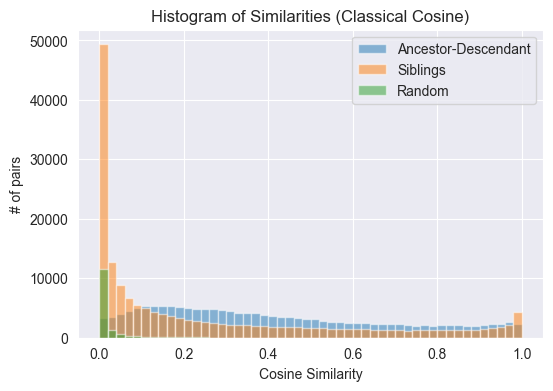

Chimeric detection for tree0: {'0000002_0000000': False, '0000008_0000001': True, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': False, '0000008_0000005': True, '0000008_0000007': True, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': False, '0000008_0000052': False, '0000008_0000059': True}


In [15]:
import os
import random
from collections import defaultdict, deque
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import stats  # for p-values, e.g. t-test

from matchms import Spectrum
from matchms.similarity import CosineGreedy, CosineHungarian

######################################################
# 0) Utility: Summaries, Stats, and Plotting
######################################################

def summarize_similarity_distribution(scores: List[float]) -> dict:
    """
    Return mean, std, median, count for a list of float scores,
    ignoring NaNs.
    """
    arr = np.array(scores)
    arr = arr[~np.isnan(arr)]
    if len(arr) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "median": float(np.median(arr)),
        "count": len(arr)
    }

def compare_distributions(distA: List[float], distB: List[float], test_type: str = "ttest") -> float:
    """
    Compare two distributions (lists of floats) with a chosen test, e.g. 'ttest' or 'ranksum'.
    Return the p-value.

    - "ttest": a standard two-sample t-test
    - "ranksum": a nonparametric Wilcoxon rank-sum test
    """
    arrA = np.array(distA)
    arrB = np.array(distB)
    arrA = arrA[~np.isnan(arrA)]
    arrB = arrB[~np.isnan(arrB)]
    if len(arrA) < 2 or len(arrB) < 2:
        return float('nan')

    if test_type.lower() == "ttest":
        _, pval = stats.ttest_ind(arrA, arrB, equal_var=False, nan_policy='omit')
        return pval
    elif test_type.lower() == "ranksum":
        _, pval = stats.ranksums(arrA, arrB)
        return pval
    else:
        raise ValueError(f"Unknown test_type: {test_type}")

def plot_histograms(
    distributions: Dict[str, List[float]],
    bins: int = 50,
    alpha: float = 0.5,
    title: str = "Histogram of Similarities",
    xlabel: str = "Similarity",
    ylabel: str = "# of pairs"
):
    """
    distributions: { "label": [scores], ... }
    Plot each distribution as a separate histogram in one figure.
    """
    plt.figure(figsize=(6,4))
    for label, scores in distributions.items():
        arr = np.array(scores)
        arr = arr[~np.isnan(arr)]
        plt.hist(arr, bins=bins, alpha=alpha, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()

def plot_histograms_by_level_pairs(level_sims_dict: Dict[Tuple[int,int], List[float]],
                                   mode: str = "Greedy"):
    """
    For each (msLevelA, msLevelB) in level_sims_dict, create a separate histogram plot.
    Each key is (lvlA, lvlB) -> list of similarity scores.
    mode indicates the type of Cosine (Greedy or Hungarian) or "Embeddings" for labeling.
    """
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        arr = np.array(simvals)
        arr = arr[~np.isnan(arr)]
        stats_lv = summarize_similarity_distribution(arr)

        plt.figure(figsize=(6,4))
        plt.hist(arr, bins=50, alpha=0.7, label=f"LvlPair: ({lvlA},{lvlB})")
        plt.xlabel(f"{mode} Similarity")
        plt.ylabel("# of pairs")
        plt.title(f"Histogram of {mode} Similarities for level pair ({lvlA},{lvlB})\n"
                  f"mean={stats_lv['mean']:.3f}, median={stats_lv['median']:.3f}, count={stats_lv['count']}")
        plt.legend()
        plt.show()

######################################################
# 1) Cosine Similarity (matchms)
######################################################

def compute_cosine_greedy_score(specA: Spectrum, specB: Spectrum,
                                tolerance: float=0.1, mz_power: float=0.0,
                                intensity_power: float=1.0) -> Tuple[float,int]:
    """
    matchms CosineGreedy. Returns (score, matched_peaks).
    """
    if specA is None or specB is None:
        return (float('nan'), 0)
    cos = CosineGreedy(tolerance=tolerance, mz_power=mz_power, intensity_power=intensity_power)
    result = cos.pair(specA, specB)
    return (result["score"], result["matches"])

def compute_cosine_hungarian_score(specA: Spectrum, specB: Spectrum,
                                   tolerance: float=0.1, mz_power: float=0.0,
                                   intensity_power: float=1.0) -> Tuple[float,int]:
    """
    matchms CosineHungarian. Returns (score, matched_peaks).
    """
    if specA is None or specB is None:
        return (float('nan'), 0)
    cos = CosineHungarian(tolerance=tolerance, mz_power=mz_power, intensity_power=intensity_power)
    result = cos.pair(specA, specB)
    return (result["score"], result["matches"])

######################################################
# 2) DreaMS Embedding Similarity
######################################################

def dreams_embedding_similarity(embA: np.ndarray, embB: np.ndarray) -> float:
    """
    Simple cosine similarity for DreaMS or other embeddings
    stored as np.ndarray or torch.Tensor.
    """
    if embA is None or embB is None:
        return float('nan')
    if isinstance(embA, torch.Tensor):
        embA = embA.cpu().numpy()
    if isinstance(embB, torch.Tensor):
        embB = embB.cpu().numpy()

    dot = np.dot(embA, embB)
    normA = np.linalg.norm(embA)
    normB = np.linalg.norm(embB)
    if normA == 0.0 or normB == 0.0:
        return 0.0
    return dot / (normA * normB)

######################################################
# 3) BFS: Node Access
######################################################

def get_spectrum(node) -> Optional[Spectrum]:
    """Return the matchms.Spectrum from a node."""
    if node is None or node.spectrum is None:
        return None
    return node.spectrum

def get_embedding_for_node(node, embeddings_dict: Dict[str, np.ndarray]) -> Optional[np.ndarray]:
    """Return embedding from a dictionary that maps identifier->embedding."""
    if node is None or node.spectrum is None:
        return None
    identifier = node.spectrum.get('identifier', None)
    if identifier is None:
        return None
    return embeddings_dict.get(identifier, None)

def get_ms_level(node) -> Optional[int]:
    """Return the ms_level from node's spectrum metadata if present."""
    if node is None or node.spectrum is None:
        return None
    ms_level_str = node.spectrum.get('ms_level', None)
    if ms_level_str is not None:
        return int(ms_level_str)
    return None

######################################################
# 4) Relationship-based Similarity
######################################################

def compute_ancestor_descendant_similarity(tree,
                                           use_embedding: bool=False,
                                           sim_fn=None,
                                           embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
                                           tolerance: float=0.1) -> List[float]:
    """
    For each parent->child in the tree, compute similarity.
    If use_embedding=False, sim_fn is (specA,specB)->(score,matched).
    If None => default CosineGreedy(tol=0.1).
    If use_embedding=True, sim_fn is (embA,embB)->float or None => dreams_embedding_similarity.
    """
    from collections import deque
    scores = []
    queue = deque([tree.root])
    while queue:
        parent = queue.popleft()
        for child in parent.children.values():
            if not use_embedding:
                specA = get_spectrum(parent)
                specB = get_spectrum(child)
                if sim_fn is None:
                    (sc, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
                else:
                    (sc, _) = sim_fn(specA, specB)
                scores.append(sc)
            else:
                embA = get_embedding_for_node(parent, embeddings_dict)
                embB = get_embedding_for_node(child, embeddings_dict)
                if sim_fn is None:
                    sc = dreams_embedding_similarity(embA, embB)
                else:
                    sc = sim_fn(embA, embB)
                scores.append(sc)
            queue.append(child)
    return scores

def compute_sibling_similarity(tree,
                               use_embedding: bool=False,
                               sim_fn=None,
                               embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
                               tolerance: float=0.1) -> List[float]:
    """
    For each parent, compute pairwise similarity among sibling nodes.
    Return a list of the resulting scores.
    """
    from collections import deque
    scores = []
    queue = deque([tree.root])
    while queue:
        parent = queue.popleft()
        siblings = list(parent.children.values())
        for i in range(len(siblings)):
            for j in range(i+1, len(siblings)):
                nodeA = siblings[i]
                nodeB = siblings[j]
                if not use_embedding:
                    specA = get_spectrum(nodeA)
                    specB = get_spectrum(nodeB)
                    if sim_fn is None:
                        (sc, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
                    else:
                        (sc, _) = sim_fn(specA, specB)
                    scores.append(sc)
                else:
                    embA = get_embedding_for_node(nodeA, embeddings_dict)
                    embB = get_embedding_for_node(nodeB, embeddings_dict)
                    if sim_fn is None:
                        sc = dreams_embedding_similarity(embA, embB)
                    else:
                        sc = sim_fn(embA, embB)
                    scores.append(sc)

        for child in siblings:
            queue.append(child)

    return scores

def random_node_pairs(
    msn_dataset,
    num_pairs: int=1000,
    use_embedding: bool=False,
    sim_fn=None,
    embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
    tolerance: float=0.1
) -> List[float]:
    """
    Gather all nodes from all trees, sample random pairs, compute similarity.
    Return list of scores.
    """
    from collections import deque
    all_nodes = []
    for tree in msn_dataset.trees:
        queue = deque([tree.root])
        while queue:
            n = queue.popleft()
            all_nodes.append(n)
            for c in n.children.values():
                queue.append(c)

    if len(all_nodes) < 2:
        return []

    scores = []
    for _ in range(num_pairs):
        A = random.choice(all_nodes)
        B = random.choice(all_nodes)
        if A is B:
            continue

        if not use_embedding:
            specA = get_spectrum(A)
            specB = get_spectrum(B)
            if sim_fn is None:
                (sc, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
            else:
                (sc, _) = sim_fn(specA, specB)
            scores.append(sc)
        else:
            embA = get_embedding_for_node(A, embeddings_dict)
            embB = get_embedding_for_node(B, embeddings_dict)
            if sim_fn is None:
                sc = dreams_embedding_similarity(embA, embB)
            else:
                sc = sim_fn(embA, embB)
            scores.append(sc)

    return scores

def detect_chimeric_branches(tree,
                             margin: float=0.2,
                             use_embedding: bool=False,
                             sim_fn=None,
                             embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
                             tolerance: float=0.1) -> Dict[str, bool]:
    """
    For each node, compare sim(node, parent) vs best sim(node, any-other).
    If best-other minus sim(node,parent) > margin => chimeric
    Return a dict: {identifier -> bool}.
    """
    from collections import deque
    all_nodes = []
    queue = deque([tree.root])
    while queue:
        n = queue.popleft()
        all_nodes.append(n)
        for c in n.children.values():
            queue.append(c)

    # BFS find parent
    def _find_parent(root, target):
        qq = deque([root])
        while qq:
            curr = qq.popleft()
            for ch in curr.children.values():
                if ch is target:
                    return curr
                qq.append(ch)
        return None

    def _node_sim(nA, nB):
        if not use_embedding:
            sA = get_spectrum(nA)
            sB = get_spectrum(nB)
            if sim_fn is None:
                (sc, _) = compute_cosine_greedy_score(sA, sB, tolerance=tolerance)
            else:
                (sc, _) = sim_fn(sA, sB)
            return sc
        else:
            eA = get_embedding_for_node(nA, embeddings_dict)
            eB = get_embedding_for_node(nB, embeddings_dict)
            if sim_fn is None:
                return dreams_embedding_similarity(eA, eB)
            else:
                return sim_fn(eA, eB)

    out_dict = {}
    for node in all_nodes:
        if node is tree.root or node.spectrum is None:
            ident = node.spectrum.get('identifier','root') if node.spectrum else 'root'
            out_dict[ident] = False
            continue
        parent = _find_parent(tree.root, node)
        if parent is None:
            ident = node.spectrum.get('identifier','???')
            out_dict[ident] = False
            continue

        sp_parent = _node_sim(node, parent)
        best_other = -1.0
        for other in all_nodes:
            if other is node or other is parent:
                continue
            sc = _node_sim(node, other)
            if sc > best_other:
                best_other = sc

        ident = node.spectrum.get('identifier','???')
        if best_other - sp_parent > margin:
            out_dict[ident] = True
        else:
            out_dict[ident] = False

    return out_dict

######################################################
# 5) Pairwise by MS Level (including same-level (2,2))
######################################################

def compute_pairwise_similarity_by_mslevel(
    tree,
    use_embedding: bool=False,
    sim_fn=None,
    embeddings_dict: Optional[Dict[str, np.ndarray]]=None,
    tolerance: float=0.1
) -> Dict[Tuple[int,int], List[float]]:
    """
    For *all* pairs of distinct nodes in the tree, compute similarity,
    group by (msLevelA, msLevelB). That includes same-level pairs
    (like (2,2)) if there exist multiple ms2 nodes in the tree.

    Return: dict of (lvlA, lvlB)->list of similarity scores.
    """
    from itertools import product

    # BFS gather nodes
    from collections import deque
    nodes = []
    queue = deque([tree.root])
    while queue:
        n = queue.popleft()
        nodes.append(n)
        for c in n.children.values():
            queue.append(c)

    level_sims = defaultdict(list)

    def _node_sim(nA, nB):
        if not use_embedding:
            sA = get_spectrum(nA)
            sB = get_spectrum(nB)
            if sim_fn is None:
                (sc, _) = compute_cosine_greedy_score(sA, sB, tolerance=tolerance)
            else:
                (sc, _) = sim_fn(sA, sB)
            return sc
        else:
            eA = get_embedding_for_node(nA, embeddings_dict)
            eB = get_embedding_for_node(nB, embeddings_dict)
            if sim_fn is None:
                return dreams_embedding_similarity(eA, eB)
            else:
                return sim_fn(eA, eB)

    # We'll do a double loop skipping same node. That way we can see all pairs
    # including same MS level (2,2).
    # We'll store (msA, msB) as is, or we could do sorted((msA,msB)).
    # If you want e.g. (2,3) and (3,2) combined, we'd unify them. We'll keep them distinct here.
    num_nodes = len(nodes)
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            nA = nodes[i]
            nB = nodes[j]
            msA = get_ms_level(nA)
            msB = get_ms_level(nB)
            if msA is None or msB is None:
                continue
            sc = _node_sim(nA, nB)
            level_sims[(msA, msB)].append(sc)
            # If you want symmetrical approach also:
            # level_sims[(msB, msA)].append(sc)

    return dict(level_sims)

def compute_same_level_similarity_limited(
    msn_dataset,
    target_level: int = 2,
    use_embedding: bool = False,
    sim_fn=None,
    embeddings_dict: Optional[Dict[str, np.ndarray]] = None,
    tolerance: float = 0.1,
    max_pairs: int = 50000
) -> List[float]:
    """
    Collect *all* nodes from ALL trees with ms_level == target_level,
    then compute pairwise similarity among them (excluding node with itself).

    If the number of total pairs is small enough (< max_pairs), do them all.
    Otherwise, randomly sample up to max_pairs pairs.

    If use_embedding=False, we interpret sim_fn as (specA, specB)->(score, matched_peaks).
      If sim_fn is None => default CosineGreedy(tol=0.1).
    If use_embedding=True, we interpret sim_fn as (embA, embB)->float.
      If sim_fn is None => default dreams_embedding_similarity.

    Returns
    -------
    List of similarity scores (float).
    """
    from collections import deque
    from math import comb
    import random

    # 1) Gather nodes at target_level
    nodes_at_level = []
    for tree in msn_dataset.trees:
        queue = deque([tree.root])
        while queue:
            node = queue.popleft()
            if node.spectrum is not None:
                lvl_str = node.spectrum.get("ms_level", None)
                if lvl_str is not None and int(lvl_str) == target_level:
                    nodes_at_level.append(node)
            for child in node.children.values():
                queue.append(child)

    n = len(nodes_at_level)
    if n < 2:
        return []

    # total number of pairs
    total_pairs = comb(n, 2)  # n*(n-1)//2

    # 2) Decide if we do all pairs or random sampling
    if total_pairs <= max_pairs:
        # do them all
        pairs = []
        for i in range(n):
            for j in range(i+1, n):
                pairs.append((nodes_at_level[i], nodes_at_level[j]))
    else:
        # randomly sample max_pairs distinct pairs
        # An easy approach is to sample from all combinations with random indices
        pairs = []
        indices = list(range(n))
        # We can do repeated random picks until we get max_pairs
        # but to ensure uniqueness, we might do reservoir approach or
        # simply do random combinations with a limit.
        # A quick method: pick random i,j until we fill max_pairs
        seen = set()
        attempts = 0
        while len(pairs) < max_pairs and attempts < max_pairs*10:
            i = random.randint(0, n-1)
            j = random.randint(0, n-1)
            if i < j:
                if (i,j) not in seen:
                    seen.add((i,j))
                    pairs.append((nodes_at_level[i], nodes_at_level[j]))
            elif j < i:
                if (j,i) not in seen:
                    seen.add((j,i))
                    pairs.append((nodes_at_level[j], nodes_at_level[i]))
            attempts += 1

    # 3) For each pair, compute similarity
    sims = []
    for (nodeA, nodeB) in pairs:
        if not use_embedding:
            specA = get_spectrum(nodeA)
            specB = get_spectrum(nodeB)
            if sim_fn is None:
                (score, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
            else:
                (score, _) = sim_fn(specA, specB)
            sims.append(score)
        else:
            embA = get_embedding_for_node(nodeA, embeddings_dict)
            embB = get_embedding_for_node(nodeB, embeddings_dict)
            if sim_fn is None:
                sc = dreams_embedding_similarity(embA, embB)
            else:
                sc = sim_fn(embA, embB)
            sims.append(sc)

    return sims


=== CosineGreedy Analysis ===
Ancestor-Descendant (Greedy) stats: {'mean': 0.4131146339090848, 'std': 0.2766338340188168, 'median': 0.358482554701118, 'count': 166808}
Sibling (Greedy) stats: {'mean': 0.2600110785894002, 'std': 0.30694811712740605, 'median': 0.11463458831076889, 'count': 173661}
Random pairs (Greedy) stats: {'mean': 0.028145786624483356, 'std': 0.08786739684075325, 'median': 0.0013978761135891166, 'count': 5000}


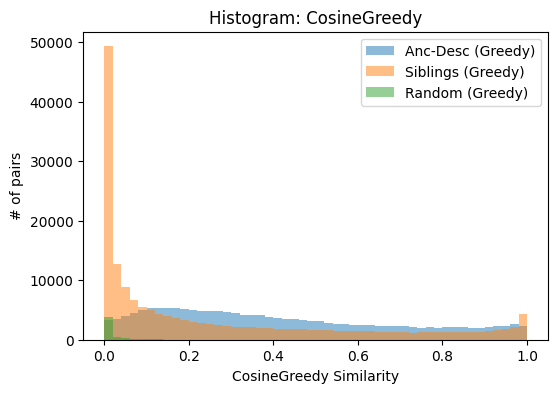


=== CosineHungarian Analysis ===
Ancestor-Descendant (Hungarian) stats: {'mean': 0.41311503931629406, 'std': 0.2766341832752525, 'median': 0.358482554701118, 'count': 166808}
Sibling (Hungarian) stats: {'mean': 0.2600110815415143, 'std': 0.3069481175822487, 'median': 0.11463458831076889, 'count': 173661}
Random pairs (Hungarian) stats: {'mean': 0.02692309211219398, 'std': 0.08251834650671383, 'median': 0.0013966714191832861, 'count': 5000}


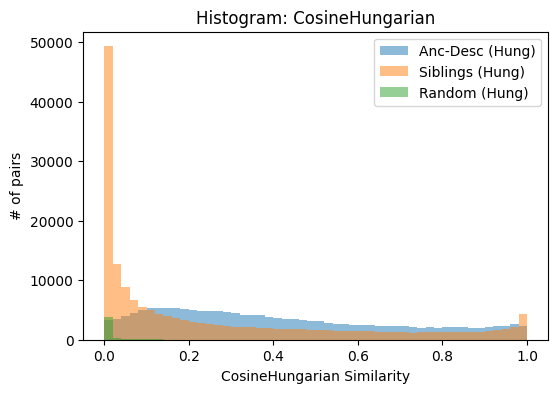


=== Checking chimeric branches on tree0 (Greedy) ===
Chimeric detection for tree0: {'0000002_0000000': False, '0000008_0000001': True, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': False, '0000008_0000005': True, '0000008_0000007': True, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': False, '0000008_0000052': False, '0000008_0000059': True}

=== MS level pair analysis (Hungarian) ===
Level pair (2, 3) -> {'mean': 0.39291368614045286, 'std': 0.29446695517700344, 'median': 0.3235879346057741, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.15920017039996986, 'std': 0.2026399596469752, 'median': 0.07434368995850654, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.2554785019529586, 'std': 0.31310530745819204, 'median': 0.10053266364833399, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.24371597288093041, 'std': 0.29400848616911196, 'median': 0.11401620645957766, 'count': 400242}
Level pair 

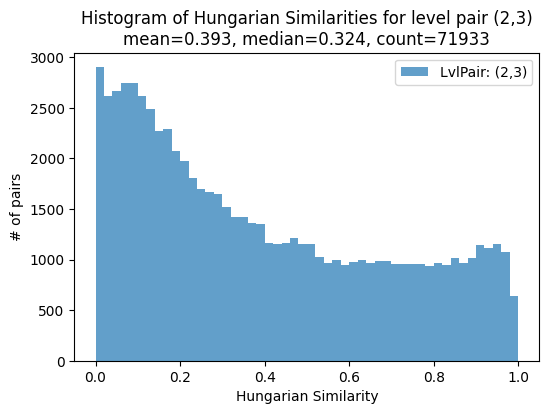

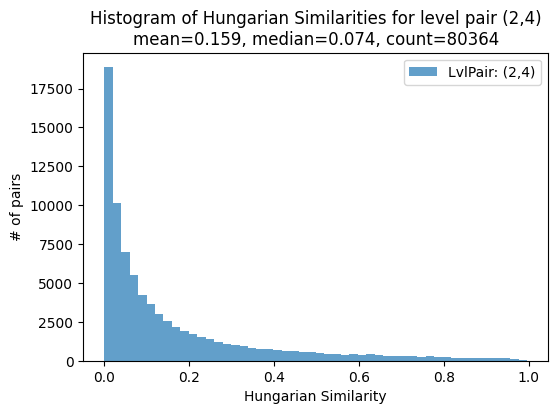

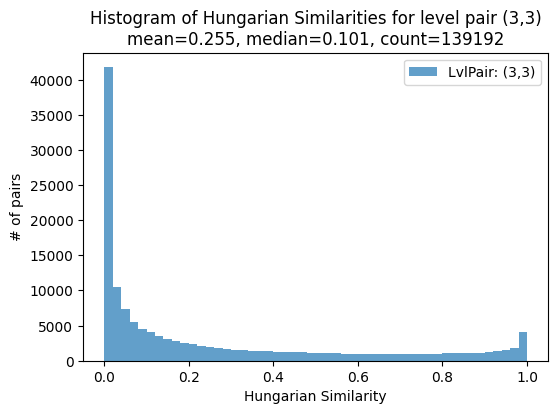

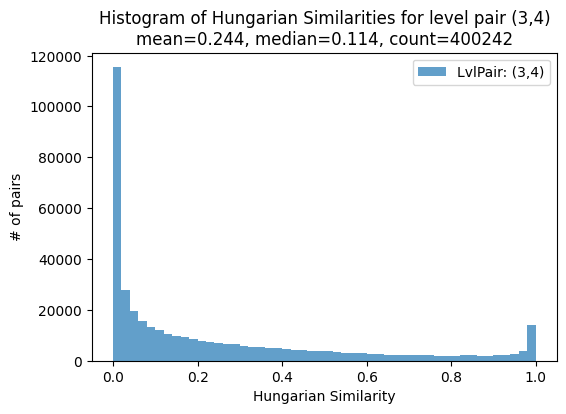

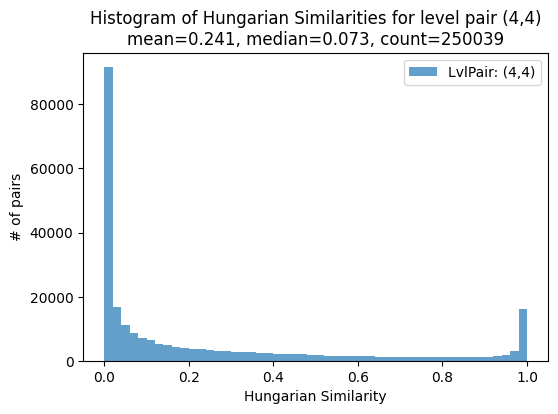

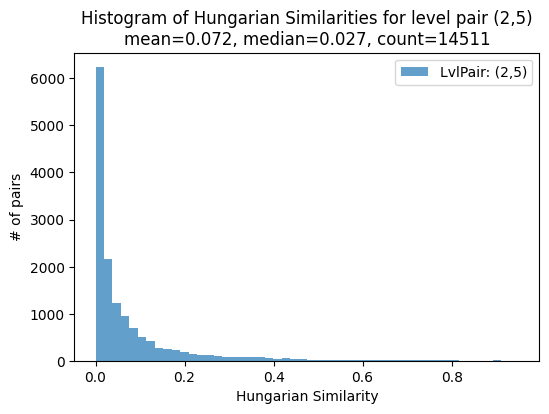

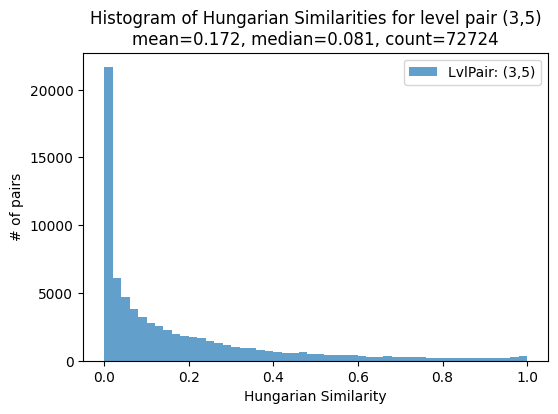

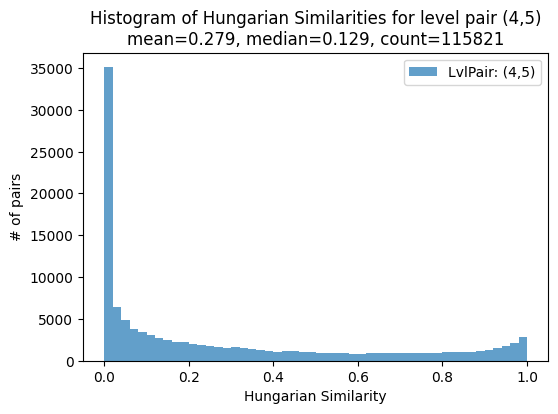

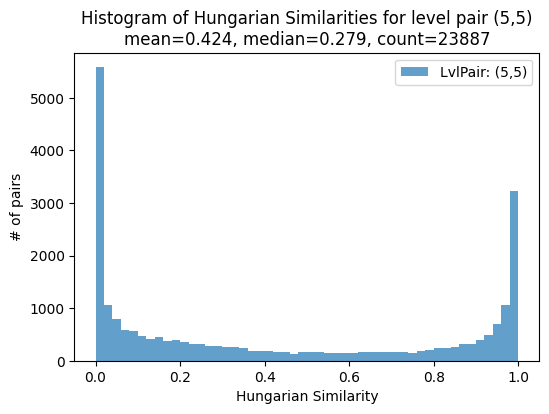

In [12]:
# (B) CosineGreedy analysis
print("\n=== CosineGreedy Analysis ===")

# 1) Anc-Desc
ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(tree,
                                                  use_embedding=False,
                                                  sim_fn=None)  # default CosineGreedy
    ad_sims.extend(sims)
stats_ad = summarize_similarity_distribution(ad_sims)
print("Ancestor-Descendant (Greedy) stats:", stats_ad)

# 2) Sibling
sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(tree, use_embedding=False, sim_fn=None)
    sib_sims.extend(sims)
stats_sib = summarize_similarity_distribution(sib_sims)
print("Sibling (Greedy) stats:", stats_sib)

# 3) Random
rand_sims = random_node_pairs(msn_dataset, num_pairs=5000, use_embedding=False)
stats_rand = summarize_similarity_distribution(rand_sims)
print("Random pairs (Greedy) stats:", stats_rand)

# Plot
plot_histograms({
    "Anc-Desc (Greedy)": ad_sims,
    "Siblings (Greedy)": sib_sims,
    "Random (Greedy)": rand_sims
}, title="Histogram: CosineGreedy", xlabel="CosineGreedy Similarity")

# (C) CosineHungarian analysis
print("\n=== CosineHungarian Analysis ===")

def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

ad_sims_hung = []
sib_sims_hung = []
rand_sims_hung = []

for tree in msn_dataset.trees:
    # Anc-Desc
    sims = compute_ancestor_descendant_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    ad_sims_hung.extend(sims)

    # Siblings
    sibs = compute_sibling_similarity(
        tree, use_embedding=False, sim_fn=hungarian_fn
    )
    sib_sims_hung.extend(sibs)

rand_sims_hung = random_node_pairs(msn_dataset, num_pairs=5000,
                                   use_embedding=False, sim_fn=hungarian_fn)

stats_ad_hung = summarize_similarity_distribution(ad_sims_hung)
stats_sib_hung = summarize_similarity_distribution(sib_sims_hung)
stats_rand_hung = summarize_similarity_distribution(rand_sims_hung)

print("Ancestor-Descendant (Hungarian) stats:", stats_ad_hung)
print("Sibling (Hungarian) stats:", stats_sib_hung)
print("Random pairs (Hungarian) stats:", stats_rand_hung)

plot_histograms({
    "Anc-Desc (Hung)": ad_sims_hung,
    "Siblings (Hung)": sib_sims_hung,
    "Random (Hung)": rand_sims_hung
}, title="Histogram: CosineHungarian", xlabel="CosineHungarian Similarity")

# (D) Chimeric detection (Greedy) on first tree
if len(msn_dataset.trees) > 0:
    print("\n=== Checking chimeric branches on tree0 (Greedy) ===")
    tree0 = msn_dataset.trees[0]
    chimeric_dict = detect_chimeric_branches(
        tree0,
        margin=0.2,
        use_embedding=False,
        sim_fn=None,  # default CosineGreedy
        tolerance=0.1
    )
    print("Chimeric detection for tree0:", chimeric_dict)

# (E) MS-Level Pair Analysis (Hungarian as example)
print("\n=== MS level pair analysis (Hungarian) ===")
all_level_sims = defaultdict(list)
def hungarian_wrapper(sA, sB):
    """This wrapper returns (score, matched_peaks)."""
    (sc, _) = compute_cosine_hungarian_score(sA, sB, tolerance=0.1)
    return (sc, 0)

for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree, use_embedding=False, sim_fn=hungarian_wrapper
    )
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        all_level_sims[(lvlA, lvlB)].extend(simvals)

# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims, mode="Hungarian")

MS2<->MS2 (Hungarian) limited stats: {'mean': 0.023165114957581973, 'std': 0.06324734197087323, 'median': 0.004746416632231128, 'count': 500}


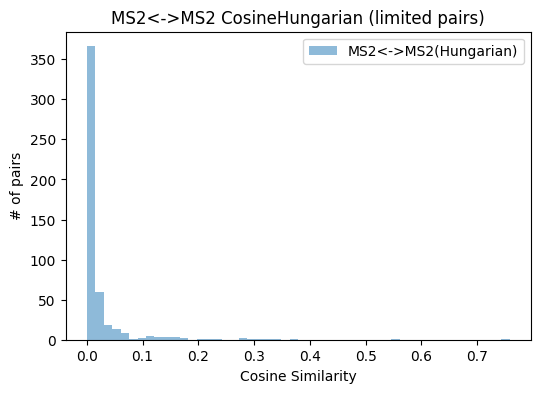

In [16]:
# Let's define a small wrapper for Hungarian scoring
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

# say we want MS level 2 only
ms2_sims_hung = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=False,
    sim_fn=hungarian_fn,
    tolerance=0.1,
    max_pairs=500   # do 500 pairs at most
)

stats_ms2_hung = summarize_similarity_distribution(ms2_sims_hung)
print("MS2<->MS2 (Hungarian) limited stats:", stats_ms2_hung)

plot_histograms({
    "MS2<->MS2(Hungarian)": ms2_sims_hung
}, title="MS2<->MS2 CosineHungarian (limited pairs)", xlabel="Cosine Similarity")

## DreaMS embedding

In [17]:
from massspecgym.tools.io import load_embeddings

embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)


=== DreaMS Embeddings Analysis ===
Ancestor-Descendant (DreaMS) stats: {'mean': 0.3994917571544647, 'std': 0.19029690325260162, 'median': 0.3847954273223877, 'count': 166808}
Sibling (DreaMS) stats: {'mean': 0.350467711687088, 'std': 0.2291901558637619, 'median': 0.3284909129142761, 'count': 173661}
Random pairs (DreaMS) stats: {'mean': 0.11854477226734161, 'std': 0.11981282383203506, 'median': 0.10860661417245865, 'count': 5000}


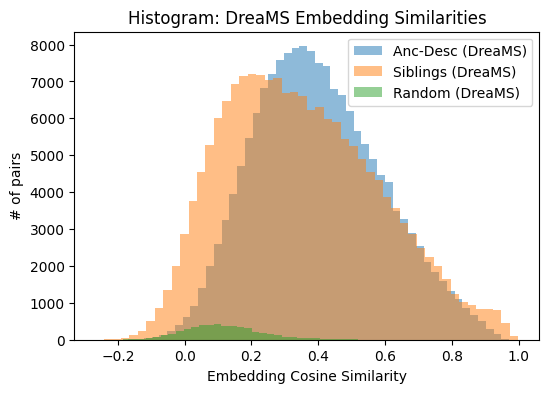


=== Checking chimeric branches on tree0 (DreaMS embeddings) ===
Chimeric detection for tree0 (embedding-based): {'0000002_0000000': False, '0000008_0000001': False, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': True, '0000008_0000005': True, '0000008_0000007': False, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': False, '0000008_0000052': True, '0000008_0000059': True}

=== MS level pair analysis (Embeddings) ===
Level pair (2, 3) -> {'mean': 0.36960604786872864, 'std': 0.18211105465888977, 'median': 0.35392341017723083, 'count': 71933}
Level pair (2, 4) -> {'mean': 0.21595095098018646, 'std': 0.13768118619918823, 'median': 0.20510858297348022, 'count': 80364}
Level pair (3, 3) -> {'mean': 0.3400874137878418, 'std': 0.23485657572746277, 'median': 0.3094925582408905, 'count': 139192}
Level pair (3, 4) -> {'mean': 0.3061775863170624, 'std': 0.22588127851486206, 'median': 0.26777011156082153

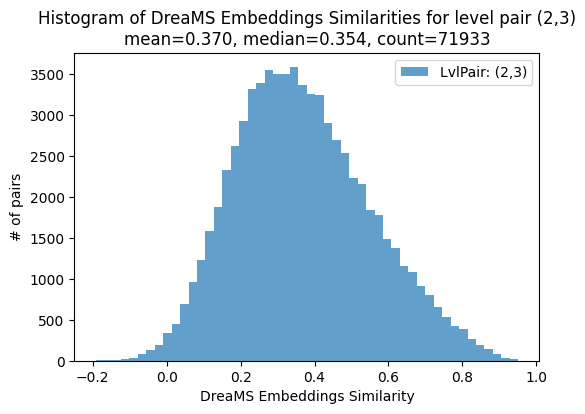

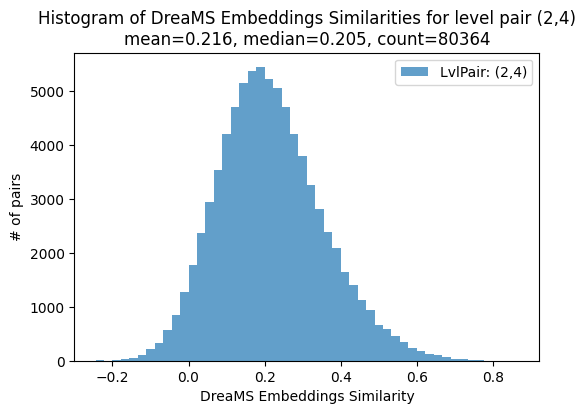

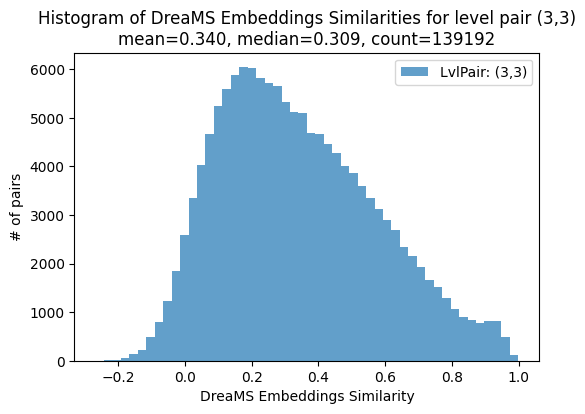

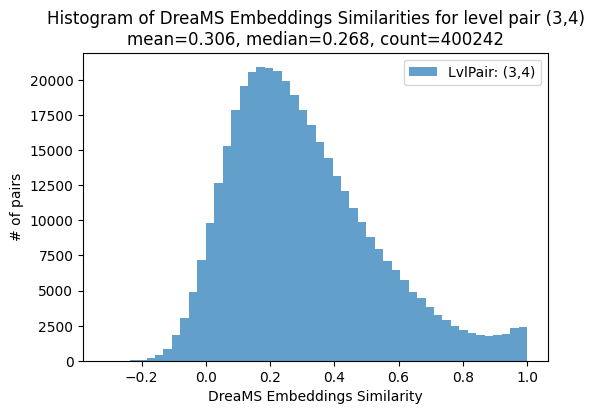

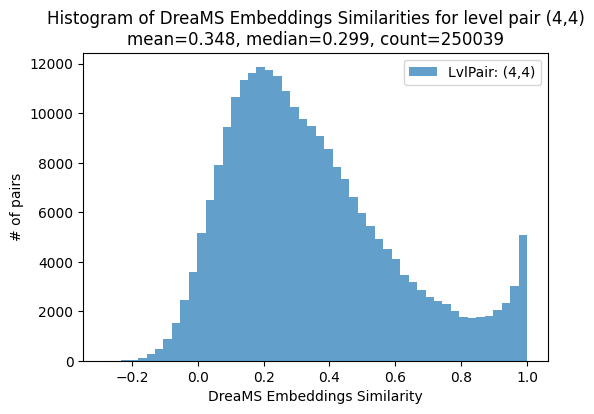

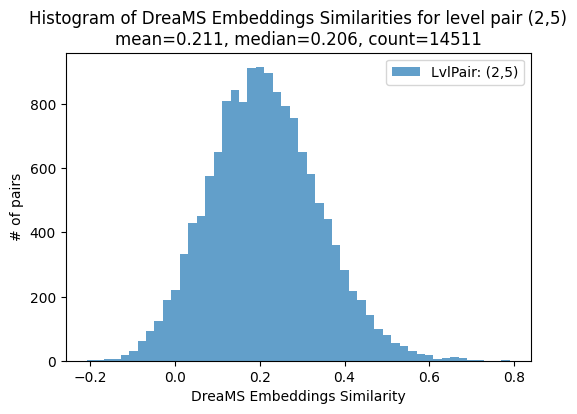

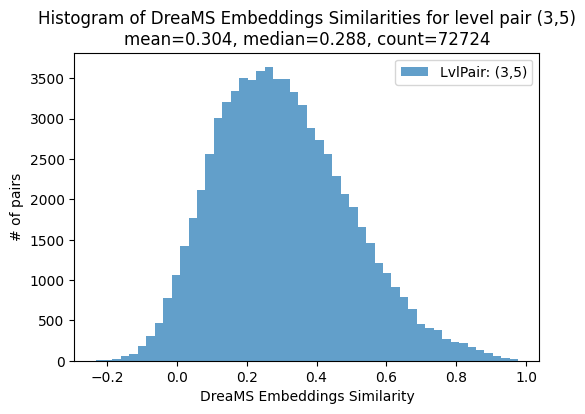

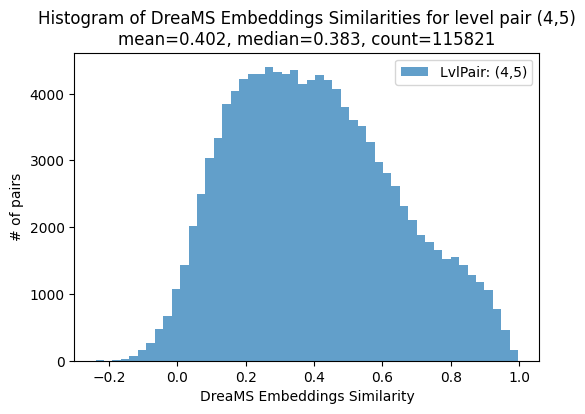

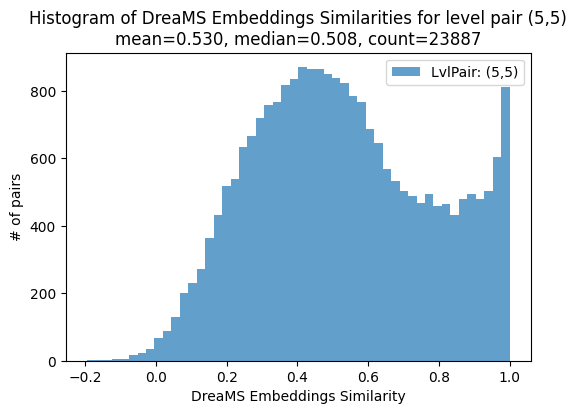

MS2<->MS2 (DreaMS embeddings) limited stats: {'mean': 0.129329115152359, 'std': 0.12242671847343445, 'median': 0.12143856287002563, 'count': 5000}


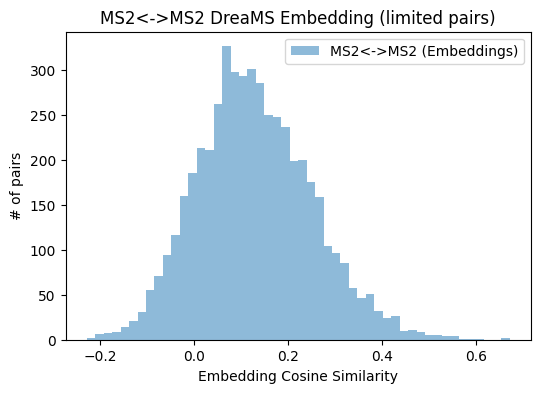

In [19]:
#################
# A) EMBEDDING-BASED: Anc-Desc, Sibling, Random
#################
print("\n=== DreaMS Embeddings Analysis ===")

# 1) Ancestor-Descendant
embed_ad_sims = []
for tree in msn_dataset.trees:
    # We set use_embedding=True, sim_fn=None => default dreams_embedding_similarity
    sims = compute_ancestor_descendant_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_ad_sims.extend(sims)
stats_ad = summarize_similarity_distribution(embed_ad_sims)
print("Ancestor-Descendant (DreaMS) stats:", stats_ad)

# 2) Siblings
embed_sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    embed_sib_sims.extend(sims)
stats_sib = summarize_similarity_distribution(embed_sib_sims)
print("Sibling (DreaMS) stats:", stats_sib)

# 3) Random pairs
embed_rand_sims = random_node_pairs(
    msn_dataset,
    num_pairs=5000,
    use_embedding=True,
    sim_fn=None,                # default dreams_embedding_similarity
    embeddings_dict=embeddings_dict
)
stats_rand = summarize_similarity_distribution(embed_rand_sims)
print("Random pairs (DreaMS) stats:", stats_rand)

# 4) Plot
plot_histograms({
    "Anc-Desc (DreaMS)": embed_ad_sims,
    "Siblings (DreaMS)": embed_sib_sims,
    "Random (DreaMS)": embed_rand_sims
},
title="Histogram: DreaMS Embedding Similarities",
xlabel="Embedding Cosine Similarity")

#################
# B) Chimeric detection (embeddings) on first tree
#################
if len(msn_dataset.trees) > 0:
    print("\n=== Checking chimeric branches on tree0 (DreaMS embeddings) ===")
    tree0 = msn_dataset.trees[0]
    chimeric_dict = detect_chimeric_branches(
        tree0,
        margin=0.2,
        use_embedding=True,
        sim_fn=None,  # default => dreams_embedding_similarity
        embeddings_dict=embeddings_dict,
        tolerance=0.1  # not used in embeddings
    )
    print("Chimeric detection for tree0 (embedding-based):", chimeric_dict)

#################
# C) MS-Level Pair Analysis (embedding-based)
#################
print("\n=== MS level pair analysis (Embeddings) ===")
all_level_sims = {}
for tree in msn_dataset.trees:
    level_sims_dict = compute_pairwise_similarity_by_mslevel(
        tree,
        use_embedding=True,
        sim_fn=None,
        embeddings_dict=embeddings_dict
    )
    # accumulate
    for (lvlA, lvlB), simvals in level_sims_dict.items():
        if (lvlA, lvlB) not in all_level_sims:
            all_level_sims[(lvlA, lvlB)] = []
        all_level_sims[(lvlA, lvlB)].extend(simvals)

# Print average for each level pair
for level_pair, vals in all_level_sims.items():
    stats_lv = summarize_similarity_distribution(vals)
    print(f"Level pair {level_pair} -> {stats_lv}")

# Optionally plot each level pair in a separate figure:
plot_histograms_by_level_pairs(all_level_sims, mode="DreaMS Embeddings")

#################
# D) MS2 <-> MS2 (embedding-based) with limited pairs
#################
ms2_sims_emb = compute_same_level_similarity_limited(
    msn_dataset,
    target_level=2,
    use_embedding=True,
    sim_fn=None,  # => dreams_embedding_similarity
    embeddings_dict=embeddings_dict,
    tolerance=0.1,  # not relevant for embeddings, but keep for consistency
    max_pairs=5000   # sample up to 500 pairs
)
stats_ms2_emb = summarize_similarity_distribution(ms2_sims_emb)
print("MS2<->MS2 (DreaMS embeddings) limited stats:", stats_ms2_emb)

plot_histograms({
    "MS2<->MS2 (Embeddings)": ms2_sims_emb
}, title="MS2<->MS2 DreaMS Embedding (limited pairs)", xlabel="Embedding Cosine Similarity")

Ancestor-Descendant similarity stats: {'mean': 0.3699364625527902, 'std': 0.2835879364185114, 'median': 0.3002427253177061, 'count': 166808}
Sibling similarity stats: {'mean': 0.23387913655790224, 'std': 0.2927818910121449, 'median': 0.0919686032629337, 'count': 173661}
Random pairs similarity stats: {'mean': 0.01660495204884054, 'std': 0.07000186369712876, 'median': 0.0, 'count': 150000}


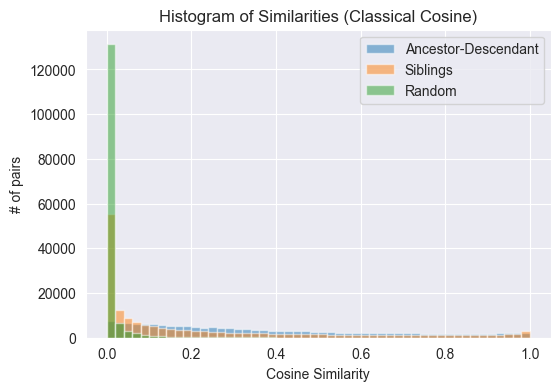

Chimeric detection for tree0: {'0000002_0000000': False, '0000008_0000001': True, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': True, '0000008_0000005': True, '0000008_0000007': True, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': True, '0000008_0000052': False, '0000008_0000059': True}


In [27]:
ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(tree,
                                                  use_embedding=False,
                                                  sim_fn=None)  # default classical cosine
    ad_sims.extend(sims)

stats_ad = summarize_similarity_distribution(ad_sims)
print("Ancestor-Descendant similarity stats:", stats_ad)

# Example 2: Sibling Similarities (Using classical cosine)
sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(tree, use_embedding=False)
    sib_sims.extend(sims)

stats_sib = summarize_similarity_distribution(sib_sims)
print("Sibling similarity stats:", stats_sib)

# Example 3: Compare with random pairs
rand_sims = random_node_pairs(msn_dataset, num_pairs=15000)
stats_rand = summarize_similarity_distribution(rand_sims)
print("Random pairs similarity stats:", stats_rand)

# Plot distributions
plt.figure(figsize=(6,4))
plt.hist(ad_sims, bins=50, alpha=0.5, label='Ancestor-Descendant')
plt.hist(sib_sims, bins=50, alpha=0.5, label='Siblings')
plt.hist(rand_sims, bins=50, alpha=0.5, label='Random')
plt.xlabel("Cosine Similarity")
plt.ylabel("# of pairs")
plt.legend()
plt.title("Histogram of Similarities (Classical Cosine)")
plt.show()

# Example 4: Detect possible chimeric nodes in one particular tree
tree0 = msn_dataset.trees[0]
chimeric_dict = detect_chimeric_branches(tree0, use_embedding=False)
print("Chimeric detection for tree0:", chimeric_dict)

Ancestor-Descendant similarity stats: {'mean': 0.3699364625527902, 'std': 0.2835879364185114, 'median': 0.3002427253177061, 'count': 166808}
Sibling similarity stats: {'mean': 0.23387913655790224, 'std': 0.2927818910121449, 'median': 0.0919686032629337, 'count': 173661}
Random pairs similarity stats: {'mean': 0.016621280594866714, 'std': 0.07010088590509665, 'median': 0.0, 'count': 150000}


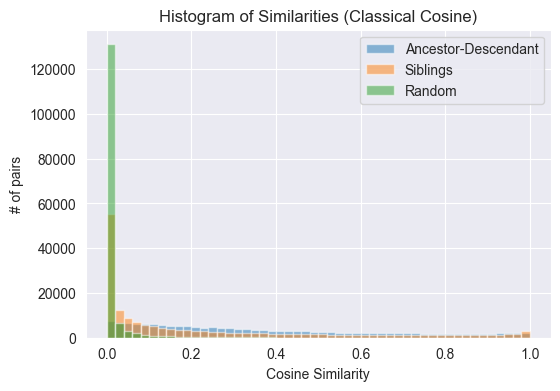

Chimeric detection for tree0: {'0000002_0000000': False, '0000008_0000001': True, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': True, '0000008_0000005': True, '0000008_0000007': True, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': True, '0000008_0000052': False, '0000008_0000059': True}


In [28]:
ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(tree,
                                                  use_embedding=False,
                                                  sim_fn=None)  # default classical cosine
    ad_sims.extend(sims)

stats_ad = summarize_similarity_distribution(ad_sims)
print("Ancestor-Descendant similarity stats:", stats_ad)

# Example 2: Sibling Similarities (Using classical cosine)
sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(tree, use_embedding=False)
    sib_sims.extend(sims)

stats_sib = summarize_similarity_distribution(sib_sims)
print("Sibling similarity stats:", stats_sib)

# Example 3: Compare with random pairs
rand_sims = random_node_pairs(msn_dataset, num_pairs=15000)
stats_rand = summarize_similarity_distribution(rand_sims)
print("Random pairs similarity stats:", stats_rand)

# Plot distributions
plt.figure(figsize=(6,4))
plt.hist(ad_sims, bins=50, alpha=0.5, label='Ancestor-Descendant')
plt.hist(sib_sims, bins=50, alpha=0.5, label='Siblings')
plt.hist(rand_sims, bins=50, alpha=0.5, label='Random')
plt.xlabel("Cosine Similarity")
plt.ylabel("# of pairs")
plt.legend()
plt.title("Histogram of Similarities (Classical Cosine)")
plt.show()

# Example 4: Detect possible chimeric nodes in one particular tree
tree0 = msn_dataset.trees[0]
chimeric_dict = detect_chimeric_branches(tree0, use_embedding=False)
print("Chimeric detection for tree0:", chimeric_dict)